In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from contextlib import contextmanager 
from io import BytesIO 
from tempfile import NamedTemporaryFile 
from transformers import PretrainedConfig, PreTrainedModel 
from transformers import set_seed
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, AutoTokenizer
from transformers import TextClassificationPipeline
from tqdm import tqdm
import json
import torch
import boto3
from psycopg2.extras import RealDictCursor
import psycopg2
import boto3
from psycopg2 import sql
from datetime import datetime
import json
import utils
import pandas as pd
import pathlib
import csv
import requests
import matplotlib.pyplot as plt
import os
from IPython.display import HTML

cities_title = ["Chicago-Naperville-Joliet","Colorado%20Springs","Denver-Aurora","Milwaukee-Waukesha-West%20Allis","San%20Francisco-Oakland-Fremont","Phoenix-Mesa-Scottsdale","Pittsburgh","Richmond","Bellingham"]
cities_list = ["Chicago","ColoradoSprings","Denver","Milwaukee","Oakland","Phoenix","Pittsburgh","Richmond","Whatcom"]
cities_id = [424,1940,7592,1638,2134,605,1338,1615,1508]
if not 'city_input' in locals():
    city_input = -1
city_in = -1

In [29]:
city_in = city_input
if city_in == -1:
    while(city_in!=0 and city_in!=1 and city_in!=2 and city_in!=3 and city_in!=4 and city_in!=5 and city_in!=6 and city_in!=7 and city_in!=8):
        city_in = int(input("Please enter a valid integer for city: 0:Chicago,IL , 1:Colorado Springs,CO , 2:Denver,CO , 3:Milwaukee,WI , 4:Oakland,CA , 5:Phoenix,AZ , 6:Pittsburg,PA , 7:Richmond,VA , 8:Whatcom/Bellingham,WA"))

city = cities_list[city_in]
url = 'https://api.openaq.org/v1/measurements?city='+cities_title[city_in]+'&parameter=pm25&limit=100000&location_id='+str(cities_id[city_in])+'&format=csv'
df_d = pd.read_csv(url)
df_d['utc'] = pd.to_datetime(df_d.utc, format='%Y-%m-%d %H:%M:%S',utc=True)
df_d.sort_values(['value'], ascending=[False], inplace=True)
df_d['utc'] = pd.to_datetime(df_d['utc']).dt.date
df_d.drop_duplicates(subset=['utc'], inplace=True)
    
cwd = os.getcwd()[:-11]
df_aq = pd.read_csv(cwd+"us-cities-aq/Text/"+city+".csv",lineterminator='\n',sep=' ',header=None,index_col=None)
df_aq.columns = ["meeting_date","num_matches","meeting_minutes","topic"]
df_aq.replace("Not Available","1/1/2020",inplace=True)

try: 
    df_aq['meeting_date'] = pd.to_datetime(df_aq.meeting_date, format='%m/%d/%Y')
except:
    df_aq['meeting_date'] = pd.to_datetime(df_aq.meeting_date)

df_gen = pd.read_csv(cwd+"us-cities-gen/Text/"+city+".csv",lineterminator='\n',sep=' ')
df_gen.columns = ["meeting_date","meeting_minutes","topic"]

Denver had 394 days with PM2.5 levels >= 15, with 42 of those days having levels >= 35 in the last 1011 days.
Percentage of days with PM2.5 levels >= 15: 38.97%
Percentage of days with PM2.5 levels >= 35: 4.15%


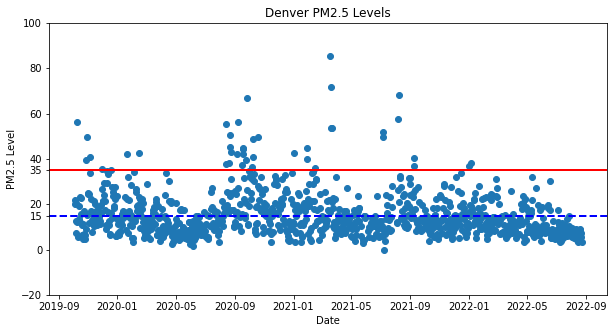

In [17]:
plt.rcParams['figure.figsize']=(10,5)
plt.scatter(df_d['utc'],df_d['value'])
plt.axhline(y=35,linewidth=2, color='r')
plt.axhline(y=15,linewidth=2, color='b',linestyle='--')
plt.ylabel("PM2.5 Level")
plt.xlabel("Date")
plt.title(city+" PM2.5 Levels")

ticks = [15,35]
plt.yticks(list(plt.yticks()[0]) + ticks)
search = df_d.apply(lambda x : True if x['value'] >= 35 else False, axis = 1)
num35 = len(df_d[search == True].index)
search = df_d.apply(lambda x : True if x['value'] >= 15 else False, axis = 1)
num15 = len(df_d[search == True].index)
percent15 = round((num15/len(df_d))*100,2)
percent35 = round((num35/len(df_d))*100,2)
print(city+" had "+str(num15)+" days with PM2.5 levels >= 15, with "+str(num35)+" of those days having levels >= 35 in the last "+str(len(df_d))+" days.")
print("Percentage of days with PM2.5 levels >= 15: "+str(percent15)+"%")
print("Percentage of days with PM2.5 levels >= 35: "+str(percent35)+"%")

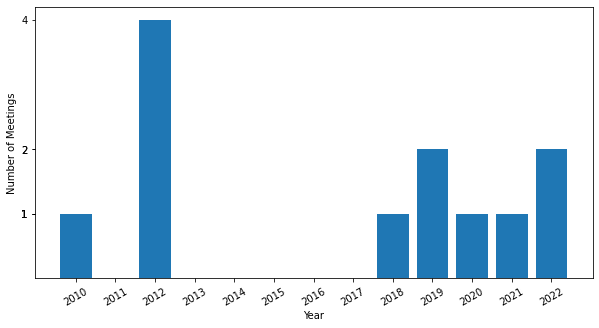

In [30]:
df_aq['meeting_date'] = pd.to_datetime(df_aq['meeting_date']).dt.year
group = df_aq.groupby(['meeting_date'],as_index=False).sum()
plt.bar(group['meeting_date'],group['num_matches'])
plt.ylabel("Number of Meetings")
plt.xlabel("Year")
plt.rcParams['figure.figsize']=(10,5)
ticks = []
i = 0
for i in range(group['meeting_date'][0],group['meeting_date'][len(group)-1]):
    ticks.append(i)
ticks.append(i+1)
plt.xticks(ticks)
plt.xticks(rotation = 30)
plt.yticks(group['num_matches'].astype(int))
print(" ")


Percentage of meetings with the topic of AQ: 0.54%
Percentage of meetings with the topic of Environment: 0.81%
Percentage of meetings with the topic of Foreign Policy: 0.9%
Percentage of meetings with the topic of Government: 6.94%
Percentage of meetings with the topic of Law: 6.17%
Percentage of meetings with the topic of Welfare: 84.64%


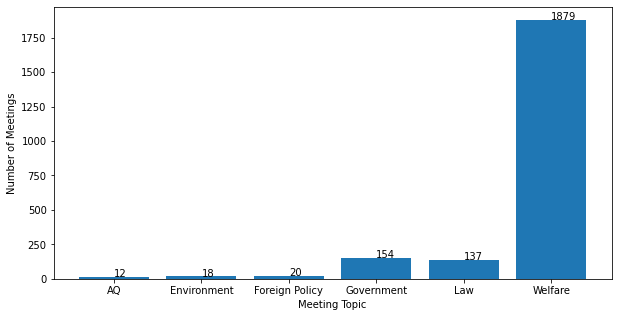

In [31]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'center')
#df_aq['meeting_minutes'] = df_aq['meeting_minutes'].strip()

x_axis = ["AQ","Environment","Foreign Policy","Government","Law","Welfare"]
y_axis = [len(df_aq)]

for i in range(1,6):
    search = df_gen.apply(lambda x : True if x['topic'] == x_axis[i].lower() else False, axis = 1)
    num = len(df_gen[search == True].index)
    y_axis.append(num)


plt.bar(x_axis,y_axis)
plt.xlabel("Meeting Topic")
plt.ylabel("Number of Meetings")
plt.rcParams['figure.figsize']=(5,10)

for i in range(len(x_axis)):
    plt.text(i,y_axis[i],y_axis[i])

total = 0
for i in y_axis:
    total += i

percents = []
j=0
for i in y_axis:
    percents.append(round((i/total)*100,2))
    print("Percentage of meetings with the topic of "+x_axis[j]+": "+str(percents[j])+"%")
    j += 1

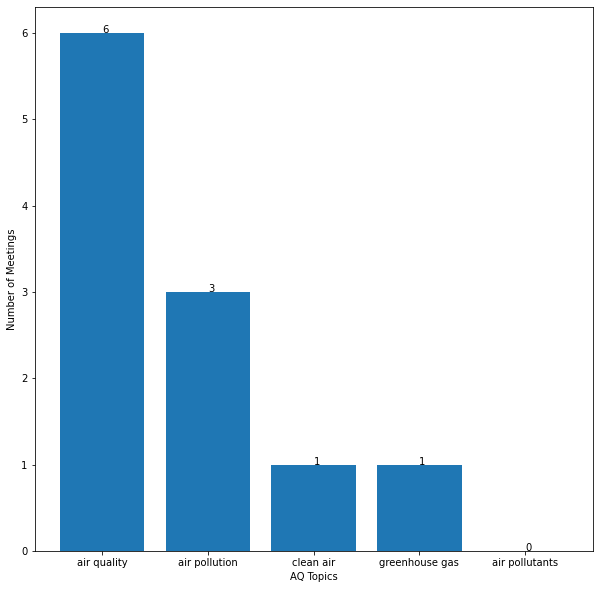

In [16]:
aq_terms = ["air quality","air pollution","clean air","greenhouse gas","air pollutants"]
aq_num = []

for i in range(0,5):
    search = df_aq.apply(lambda x : True if x['topic'] == aq_terms[i].lower() else False, axis = 1)
    num = len(df_aq[search == True].index)
    aq_num.append(num)

plt.bar(aq_terms,aq_num)
plt.xlabel("AQ Topics")
plt.ylabel("Number of Meetings")
plt.rcParams['figure.figsize']=(5,10)
for i in range(len(aq_terms)):
    plt.text(i,aq_num[i],aq_num[i])
city_in = -1
city_input = -1